In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

artist_id to name
暂时不用

## artist_id 别名规范化字典
alias_map 别名 -> 实名 

In [2]:
alias_map ={}
n=0
eno =0
dno =0
with open("artist_alias.txt",encoding="utf8") as f:
    for l in f:
        n=n+1
        m = re.match(r"(\d+)\t(\d+)",l)
        eles = m.groups() if m is not None else () 
        if len(eles) is 2:
            if alias_map.get(eles[0]) is None:    
                alias_map[eles[0]] = eles[1]
            else:
                dno +=1
#                 print(str(n)+" - duplicate: "+l+"["+alias_map[eles[0]]+"]")
        else:
            eno+=1
#             print(str(n)+" - error: "+l)
print("error count : "+str(eno))
print("dupli count : "+str(dno))
print("lines count : "+str(n))

"""
error count : 2135
dupli count : 0
lines count : 193027
"""

np.save("obj/alias_map.npy",alias_map)

error count : 2135
dupli count : 0
lines count : 193027


'\nerror count : 2135\ndupli count : 0\nlines count : 193027\n'

# 1. 从文件中构造原始矩阵

In [3]:
alias_map = np.load("obj/alias_map.npy",allow_pickle=True).item()

In [10]:
"""
记录id到矩阵索引的映射
"""
user_id_index = {}
user_cnt = 0 # index 计数
artist_id_index = {}
artist_cnt = 0 # index 计数


# 测试集保留
test = {}  #（ (user,artist) : score )
# 训练集记录
train_map = {}  # ((user_index,artist_index) : score)

# 构造训练集和测试集
import random
def add_item(user, artist, score):
    """
    需要 alias_map
    20%几率将数据置0，作为测试集
    """
    # artist 别名规范化
    artist = alias_map.get(artist,artist)
    
    # 测试集：从训练集中随机抽取20%记录score作为测试，并置score=0写入训练集
    import random
    if random.random() < 0.2:
        test[(user,artist)] = score
        score = 0
        
    # 训练集
    '''
    user in index ? index : new index, new row
    artist in index ? index : new index, new col
    '''
    global user_cnt
    user_index=user_cnt
    if user in user_id_index:
        user_index = user_id_index[user]
    else:
        user_id_index[user] = user_index
        user_cnt +=1
        
    global artist_cnt
    artist_index=artist_cnt
    if artist in artist_id_index:
        artist_index = artist_id_index[artist]
    else:
        artist_id_index[artist] = artist_index
        artist_cnt +=1
    
    return (user_index,artist_index),score


# 读取文件
n=0
eno =0

import random

with open("user_artist_data.txt",encoding="utf8") as f:
    # 文件总计2400+w行
    for l in f:
#         if random.random() < 0.1:
            n=n+1
            m = re.match(r"(\d+) (\d+) (\d+)",l)
            eles = m.groups() if m is not None else () 
            if len(eles) is 3:
                key,value = add_item(eles[0], eles[1], int(eles[2]))
                train_map[key] = value
            else:
                eno+=1
    #             print(str(n)+" - error: "+l)
            if n%100000 is 0:
                print(f"compete {n}", end="\r")

print("error count : "+str(eno))
print("lines count : "+str(n))

error count : 00
lines count : 24296858


In [15]:
type(train_map.keys())

dict_keys

In [29]:
index = pd.DataFrame( [ [_[0],_[1]] for _ in train_map.keys()] , columns=['user','item'])

In [52]:
# 听歌很少的人
index["user"].value_counts()[ index["user"].value_counts() <= 2]

44533     2
70495     2
19760     2
10952     2
68734     2
135997    2
20856     2
4345      2
9899      2
35919     2
51536     2
68618     2
118977    2
35916     2
51770     2
64225     2
134410    2
91807     2
59451     2
124999    2
135560    2
60408     2
15131     2
146257    2
10366     2
146107    2
80388     2
53620     2
141422    2
43916     2
         ..
20786     1
6144      1
58309     1
135550    1
140188    1
61226     1
120894    1
66295     1
84496     1
71720     1
95368     1
107493    1
43079     1
113764    1
147809    1
130154    1
4405      1
131738    1
141330    1
71735     1
108652    1
62655     1
123893    1
65174     1
18997     1
296       1
144600    1
20794     1
104490    1
73482     1
Name: user, Length: 5755, dtype: int64

In [55]:
# 小众歌曲
index["item"].value_counts()[ index["item"].value_counts() <= 2]

583885     2
1039980    2
1036953    2
908687     2
920281     2
776477     2
892435     2
960542     2
352049     2
1026107    2
529583     2
1055514    2
699067     2
298015     2
417622     2
859703     2
809106     2
1113207    2
610883     2
1056596    2
1153830    2
774681     2
166732     2
514204     2
1248998    2
822555     2
1103605    2
1265390    2
1236428    2
1105740    2
          ..
320709     1
287957     1
271581     1
369901     1
402589     1
337149     1
713989     1
681237     1
664861     1
779557     1
746805     1
517285     1
418965     1
1337044    1
140317     1
1320668    1
1435364    1
1418988    1
1402612    1
1386236    1
156693     1
222261     1
435341     1
205885     1
58437      1
1212344    1
1195952    1
107629     1
1245096    1
1089012    1
Name: item, Length: 1195685, dtype: int64

In [57]:
unpop_music = set( index["item"].value_counts()[ index["item"].value_counts() <= 2].index )

In [60]:
train_map_pop = {key: value for key, value in train_map.items() if key[1] not in unpop_music}

In [48]:
m_valid_set = set( [ _[0] for _ in train_map.keys() ] )

In [50]:
len(m_valid_set)

148111

In [51]:
n_valid_set = set( [ _[1] for _ in train_map.keys() ] )

In [52]:
len(n_valid_set)

1568126

In [69]:
artist_cnt_pop = len( set( [ _[1] for _ in train_map_pop.keys() ] ) ) 

# 2. 矩阵分解

## 2.2 UV 分解 

train 为原始矩阵 $M$

UV 分解即  $M \approx UV = P $

初始化 UV 矩阵 分别为 $m*k, k*n$

In [70]:
K = 5  # 隐含主题个数，经验值

m,n = user_cnt,artist_cnt_pop

# 初始化 U，V 矩阵为1
global u,v
u = np.ones((m,K))
v = np.ones((K,n))

对$u_{rs}$变化,使得𝑀和𝑈𝑉间𝑅𝑀𝑆𝐸最小, $u_{rs}$局部最优取值为$x$:

$$ x = \frac{\sum_j v_{sj}( m_{rj} - \sum_{k\neq s} u_{rk}v_{kj} )}  
            {\sum_j v_{sj}^2  }  $$
            
对$V$类似

In [72]:
# 减少重复计算，先存储分母
down_sum_vsj = [ sum( [ (v[s,j])**2 for j in range(n) ] ) for s in range(K) ]

In [74]:
for r in range(m):
    for s in range(K):
        # 遍历U每个位置
        print( f"processing {r},{s} in U .", end="\r" )
        up_sum = 0
        for j in range(n):
            value = train_map.get( (r,j), 0 )
            if value > 0:
                uv_sum = sum([ u[r,k]* v[k,j] for k in range(K) if k!=s ])
                up_sum += v[s,j] * ( value - uv_sum )
        u[r,s] = up_sum / down_sum_vsj[s] if down_sum_vsj[s] >0 else 0
        
np.save("obj/u.npy",u)
print("processing U completed.")

KeyboardInterrupt: 

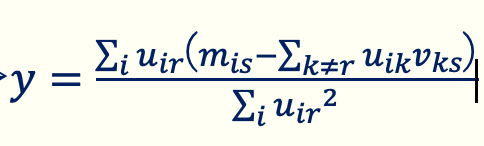


In [58]:
# 减少重复计算，先存储分母
down_sum_uir = [ sum( [ (v[r,i])**2 for i in range(m) ] ) for r in range(K) ]

In [70]:
for r in range(K):
    for s in range(n):
        # 遍历V每个位置
        print( f"processing {r},{s} in V ", end="\r" )
        up_sum = 0
        for i in range(m):
            value = train_map.get( (i,s), 0 )
            if value > 0:
                uv_sum = sum([ u[i,k]* v[k,s] for k in range(K) if k!=r ])
                up_sum += u[i,r] * ( value - uv_sum )
        v[r,s] = up_sum / down_sum_uir[r] if down_sum_uir[r]>0 else 0
        
np.save("obj/v.npy",v)
print("processing V completed.")

KeyboardInterrupt: 

In [69]:
u[0]

array([0.00185763, 0.00227837, 0.00269893, 0.00311932, 0.00353952,
       0.00395955, 0.00437941, 0.00479908, 0.00521858, 0.00563791])

In [71]:
v[0,0:10]

array([ 1.03878917e+00, -4.65453372e-04,  1.62140522e-04,  4.24161114e+00,
        6.22998909e-01, -2.49712750e-04,  1.11139671e+00,  1.01567830e+00,
        6.69085761e+00,  1.51305561e-02])